In [1]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=8b0188f2610facd9ba3eab6af47eee3db3228c098fc73d934c5fbe8cd17d7709
  Stored in directory: /root/.cache/pip/wheels/b3/50/6c/0a82c1358b4da2dbd9c1bb17e0f89467db32812ab236dbf6d5
Successfully built gym
  Attempting uninstal

ResNet đã làm thay đổi đáng kể quan điểm về cách tham số hóa các hàm số trong mạng nơ-ron sâu. Ở một mức độ nào đó, DenseNet có thể được coi là phiên bản mở rộng hợp lý của ResNet. Để hiểu cách đi đến kết luận đó, ta cần tìm hiểu một chút lý thuyết. Nhắc lại công thức khai triển Taylor cho hàm một biến vô hướng như sau
$$
f(x) = f(0) + f'(x) x + \frac{1}{2} f''(x) x^2 + \frac{1}{6} f'''(x) x^3 + o(x^3).
$$

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# 8.7.1. Phân tách Hàm số
Nhắc lại khai triển Taylor cho các hàm cho điểm $x = 0$ nó có thể được viết như
$$
f(x) = f(0) + x \cdot \left[f'(0) + x \cdot \left[\frac{f''(0)}{2!}  + x \cdot \left[\frac{f'''(0)}{3!}  + \ldots \right]\right]\right].
$$

Điểm mấu chốt là khai triển Taylor phân tách hàm số thành các số hạng có bậc tăng dần. Tương tự, ResNet phân tách các hàm số thành
$$
f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).
$$

Cụ thể, ResNet tách hàm số $f$ thành một số hạng tuyến tính đơn giản và một số hạng phi tuyến phức tạp hơn. Nếu ta muốn tách ra thành nhiều hơn hai số hạng thì sao? Một giải pháp đã được đề xuất bởi [Huang et al., 2017] trong kiến trúc DenseNet. Kiến trúc này đạt được hiệu suất kỉ lục trên tập dữ liệu ImageNet.

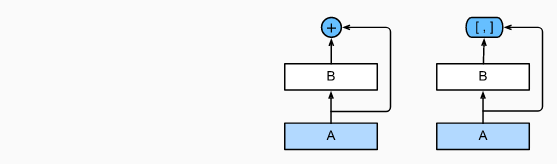

Như được thể hiện trong hình trên, điểm khác biệt chính là DenseNet nối đầu ra lại với nhau thay vì cộng lại như ở ResNet. Kết quả là ta thực hiện một ánh xạ từ $x$ đến các giá trị của nó sau khi áp dụng một chuỗi các hàm với độ phức tạp tăng dần.
$$
\mathbf{x} \to \left[\mathbf{x}, f_1(\mathbf{x}), f_2(\mathbf{x}, f_1(\mathbf{x})), f_3(\mathbf{x}, f_1(\mathbf{x}), f_2(\mathbf{x}, f_1(\mathbf{x})), \ldots\right].
$$

Cuối cùng, tất cả các hàm số này sẽ được kết hợp trong một Perceptron đa tầng để giảm số lượng đặc trưng một lần nữa. Lập trình thay đổi này khá đơn giản — thay vì cộng các số hạng với nhau, ta sẽ nối chúng lại. Cái tên DenseNet phát sinh từ việc đồ thị phụ thuộc giữa các biến trở nên khá dày đặc. Tầng cuối cùng của một chuỗi như vậy được kết nối “dày đặc” tới tất cả các tầng trước đó. Thành phần chính của DenseNet là các khối dày đặc và các tầng chuyển tiếp. Các khối dày đặc định nghĩa cách các đầu vào và đầu ra được nối với nhau, trong khi các tầng chuyển tiếp kiểm soát số lượng kênh sao cho nó không quá lớn. Các kết nối dày đặc được biểu diễn trong hình dưới.

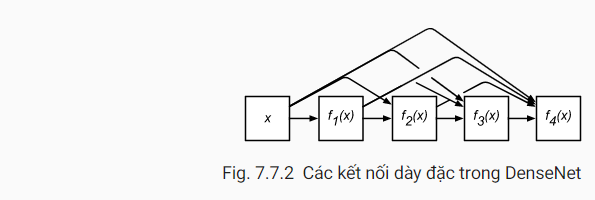

# 8.7.2. Khối dày đặc

DenseNet sử dụng kiến trúc “chuẩn hóa theo batch, hàm kích hoạt và phép tích chập” đã qua sửa đổi của ResNet (xem phần bài tập trong Section 8.6). Đầu tiên, ta sẽ lập trình kiến trúc này trong hàm `conv_block`.

In [3]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

Một khối dày đặc bao gồm nhiều khối conv_block với cùng số lượng kênh đầu ra. Tuy nhiên, ta sẽ nối đầu vào và đầu ra của từng khối theo chiều kênh khi tính toán lượt truyền xuôi.

In [4]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

Trong ví dụ sau, ta sẽ định nghĩa một khối dày đặc gồm hai khối tích chập với 10 kênh đầu ra. Với một đầu vào gồm 3 kênh, ta sẽ nhận được một đầu ra với $3+2×10=23$ kênh. Số lượng kênh của khối tích chập kiểm soát sự gia tăng của số lượng kênh đầu ra so với số lượng kênh đầu vào. Số lượng kênh này còn được gọi là tốc độ tăng trưởng (growth rate).

In [5]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

# 8.7.3. Tầng chuyển tiếp.

Mỗi khối dày đặc sẽ làm tăng thêm số lượng kênh. Nhưng việc thêm quá nhiều kênh sẽ tạo nên một mô hình phức tạp quá mức. Do đó, một tầng chuyển tiếp sẽ được sử dụng để kiểm soát độ phức tạp của mô hình. Tầng này dùng một tầng tích chập $1×1$ để giảm số lượng kênh, theo sau là một tầng gộp trung bình với sải bước bằng 2 để giảm một nửa chiều cao và chiều rộng, từ đó giảm độ phức tạp của mô hình hơn nữa.

In [6]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

Áp dụng một lớp chuyển tiếp với 10 kênh cho đầu ra của khối dày đặc trong ví dụ trước. Điều này làm giảm số lượng kênh đầu ra xuống còn 10 và giảm một nửa chiều cao và chiều rộng.

In [7]:
blk = transition_block(10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

# 8.7.4. Mô hình mạng dày đặc

Tiếp theo, ta sẽ xây dựng một mô hình DenseNet. Đầu tiên, DenseNet sử dụng một tầng tích chập và một tầng gộp cực đại như trong ResNet.

In [8]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Sau đó, tương tự như cách ResNet sử dụng bốn khối phần dư, DenseNet cũng dùng bốn khối dày đặc. Và cũng giống như ResNet, ta có thể tùy chỉnh số lượng tầng tích chập được sử dụng trong mỗi khối dày đặc. Ở đây, ta sẽ đặt số lượng khối tích chập bằng 4 để giống với kiến trúc ResNet-18 trong phần trước. Ngoài ra, ta đặt số lượng kênh (tức tốc độ tăng trưởng) của các tầng tích chập trong khối dày đặc là 32, vì vậy 128 kênh sẽ được thêm vào trong mỗi khối dày đặc.

Trong ResNet, chiều cao và chiều rộng được giảm sau mỗi khối bằng cách sử dụng một khối phần dư với sải bước bằng 2. Ở đây, ta sẽ sử dụng tầng chuyển tiếp để làm giảm đi một nửa chiều cao, chiều rộng và số kênh.

In [9]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

# 8.7.5. Training

Vì chúng ta đang sử dụng một mạng sâu hơn ở đây nên trong phần này, chúng ta sẽ giảm chiều cao và chiều rộng đầu vào từ 224 xuống 96 để đơn giản hóa việc tính toán

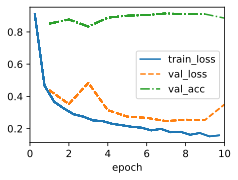

In [10]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)